### 과제 2: 배송 성과 분석
**과제 2: 배송 성과 분석 및 지역별 물류 최적화 방안**
주문부터 배송 완료까지의 시간을 분석하고, 지역별 배송 성과 차이를 파악하여 물류 최적화 방안을 도출하세요. 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향도 함께 분석하세요



## EDA 진행 
**목표:** 지역별 배송 시간의 평균과 분포를 확인하고, 배송 시간과 고객 리뷰 점수 간의 관계를 파악합니다.

### **분석 로직:**

1. **날짜/시간 변환**: `orders` 데이터셋의 `order_purchase_timestamp`와 `order_delivered_customer_date`를 `datetime` 타입으로 변환합니다.
2. **배송 시간 계산**: `order_delivered_customer_date`에서 `order_purchase_timestamp`를 빼서 배송 소요 시간을 계산합니다.
3. **데이터 병합**: `orders`와 `geolocation` 데이터셋을 병합하여 주문별 지역 정보를 추가합니다. 또한, `orders`와 `reviews` 데이터셋을 병합하여 주문별 리뷰 점수를 연결합니다.
4. **지역별 분석**: `customer_state`를 기준으로 그룹화하여 지역별 평균 배송 시간을 계산합니다.
5. **상관관계 분석**: 배송 소요 시간과 `review_score` 간의 상관계수를 계산합니다.

### **시각화 계획:**

- **박스플롯**: 지역별(주/도시) 배송 시간의 분포를 한눈에 비교하기 위해 박스플롯을 그립니다.
- **산점도**: 배송 소요 시간과 리뷰 점수 간의 관계를 시각적으로 확인하기 위해 산점도를 그립니다.
- **히스토그램**: 리뷰 점수별(1~5점) 배송 소요 시간의 분포를 비교하는 히스토그램을 그립니다.


오늘 진행할 내용은  
**과제 2: 배송 성과 분석 및 지역별 물류 최적화 방안**
주문부터 배송 완료까지의 시간을 분석하고, 지역별 배송 성과 차이를 파악하여 물류 최적화 방안을 도출하세요. 배송 지연이 고객 만족도(리뷰 점수)에 미치는 영향도 함께 분석 




# 데이터 전처리 코드 

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
# 폰트 깨짐 방지: Matplotlib에 한글 폰트 설정
plt.rc('font', family='AppleGothic')
# 마이너스 기호 깨짐 방지
plt.rc('axes', unicode_minus=False)
# 경고 무시
import warnings
warnings.filterwarnings('ignore')

# 주요 테이블 로딩

customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
category_name = pd.read_csv("product_category_name_translation.csv")
geolocation= pd.read_csv("olist_geolocation_dataset.csv")


### 데이터 형 변환 (포르투갈어-> 영어, date_time 형식으로 변환)

In [2]:
# 각 데이터셋 크기 확인
datasets = {
    "customers": customers,
    "orders": orders,
    "order_items": order_items,
    "products": products,
    "sellers": sellers,
    "payments": payments,
    "reviews": reviews,
    "category_name": category_name,
    "geolocation": geolocation
}

for name, df in datasets.items():
    print(f"{name}: {df.shape}")
    display(df.head(2))  # 앞부분 2행만 미리보기


# ======================
# [1] Products 카테고리명 번역 (포르투갈어 → 영어)
# ======================
products = pd.read_csv("olist_products_dataset.csv")
category_translation = pd.read_csv("product_category_name_translation.csv")

# 병합 후 컬럼 정리
products = (
    products.merge(category_translation, on="product_category_name", how="left")
            .drop("product_category_name", axis=1)
            .rename(columns={"product_category_name_english": "product_category_name"})
)

print("\n=== 변환 후 'products' 카테고리 예시 ===")
print(products["product_category_name"].head())


# ======================
# [2] Orders 날짜 컬럼 변환
# ======================
datetime_cols = [
    "order_purchase_timestamp",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
# orders 데이터셋의 모든 날짜/시간 관련 컬럼을 datetime 타입으로 변환
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])



# ======================
# [3] Reviews 날짜 컬럼 변환
# ======================
reviews[["review_creation_date", "review_answer_timestamp"]] = reviews[
    ["review_creation_date", "review_answer_timestamp"]
].apply(pd.to_datetime, errors="coerce")

print("\n=== Reviews 날짜 컬럼 dtype 확인 ===")
print(reviews[["review_creation_date", "review_answer_timestamp"]].dtypes)




customers: (99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


orders: (99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


order_items: (112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


products: (32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


sellers: (3095, 4)


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


payments: (103886, 5)


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


reviews: (99224, 7)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


category_name: (71, 2)


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


geolocation: (1000163, 5)


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP



=== 변환 후 'products' 카테고리 예시 ===
0         perfumery
1               art
2    sports_leisure
3              baby
4        housewares
Name: product_category_name, dtype: object

=== Reviews 날짜 컬럼 dtype 확인 ===
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object


### 결측치 처리

- orders: 배송 완료일(order_delivered_customer_date) 없는 주문 제거 ✅
- orders: 결제 승인일(order_approved_at) 없는 주문 제거 ✅
- reviews: 코멘트 결측치 → "no comment" 대체 ✅

In [3]:
# orders 데이터셋을 불러옵니다.
# 사용자 정의 변수명을 참조하여 코드를 작성합니다.
print("=== 'orders' 데이터셋 결측치 현황 ===")
print(orders.isnull().sum())

# 배송 완료일(`order_delivered_customer_date`)이 없는 주문은 배송이 완료되지 않은 상태입니다.
# 배송 성과 분석을 위해 이 행들을 제거합니다.
orders.dropna(subset=['order_delivered_customer_date'], inplace=True)
print("\n배송 미완료 주문 제거 후 데이터 크기:", orders.shape)

# 추가적으로, 결제 승인일(`order_approved_at`)이 없는 주문도 분석에서 제외할 수 있습니다.
# 이는 유효하지 않은 주문으로 간주될 수 있기 때문입니다.
orders.dropna(subset=['order_approved_at'], inplace=True)
print("\n결제 미승인 주문 제거 후 최종 데이터 크기:", orders.shape)
print("\n결제 미승인 주문 제거 후 최종 데이터 크기:", orders .shape)


# 결측치가 제거된 최종 데이터셋의 결측치 현황을 다시 확인합니다.
print("\n=== 최종 데이터셋 결측치 재확인 ===")
print(orders.isnull().sum())

# 결측치가 제거된 데이터셋의 상위 5개 행을 확인합니다.
print("\n=== 최종 데이터셋 미리보기 ===")
print(orders.head())

# reviews 데이터셋을 불러옵니다.
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

print("=== 'olist_order_reviews_dataset.csv' 결측치 현황 ===")
print(reviews.isnull().sum())

# 코멘트 관련 컬럼(`review_comment_title`, `review_comment_message`)의 결측치는
# 고객이 코멘트를 남기지 않았음을 의미하므로, 'no comment'로 채울 수 있습니다.
reviews['review_comment_title'].fillna('no comment', inplace=True)
reviews['review_comment_message'].fillna('no comment', inplace=True)

print("\n결측치 처리 후 현황:")
print(reviews.isnull().sum())

=== 'orders' 데이터셋 결측치 현황 ===
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

배송 미완료 주문 제거 후 데이터 크기: (96476, 8)

결제 미승인 주문 제거 후 최종 데이터 크기: (96462, 8)

결제 미승인 주문 제거 후 최종 데이터 크기: (96462, 8)

=== 최종 데이터셋 결측치 재확인 ===
order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     1
order_delivered_customer_date    0
order_estimated_delivery_date    0
dtype: int64

=== 최종 데이터셋 미리보기 ===
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20de

## 이상값 처리

- 이상치 처리
    - orders: 배송 소요일(delivery_time_days) IQR 기반 제거 ✅
    - order_items: 가격(price) IQR 기반 제거 ✅
    - products: 무게(product_weight_g) IQR 기반 제거 ✅
    - payments: 결제 금액(payment_value) IQR 기반 제거 ✅

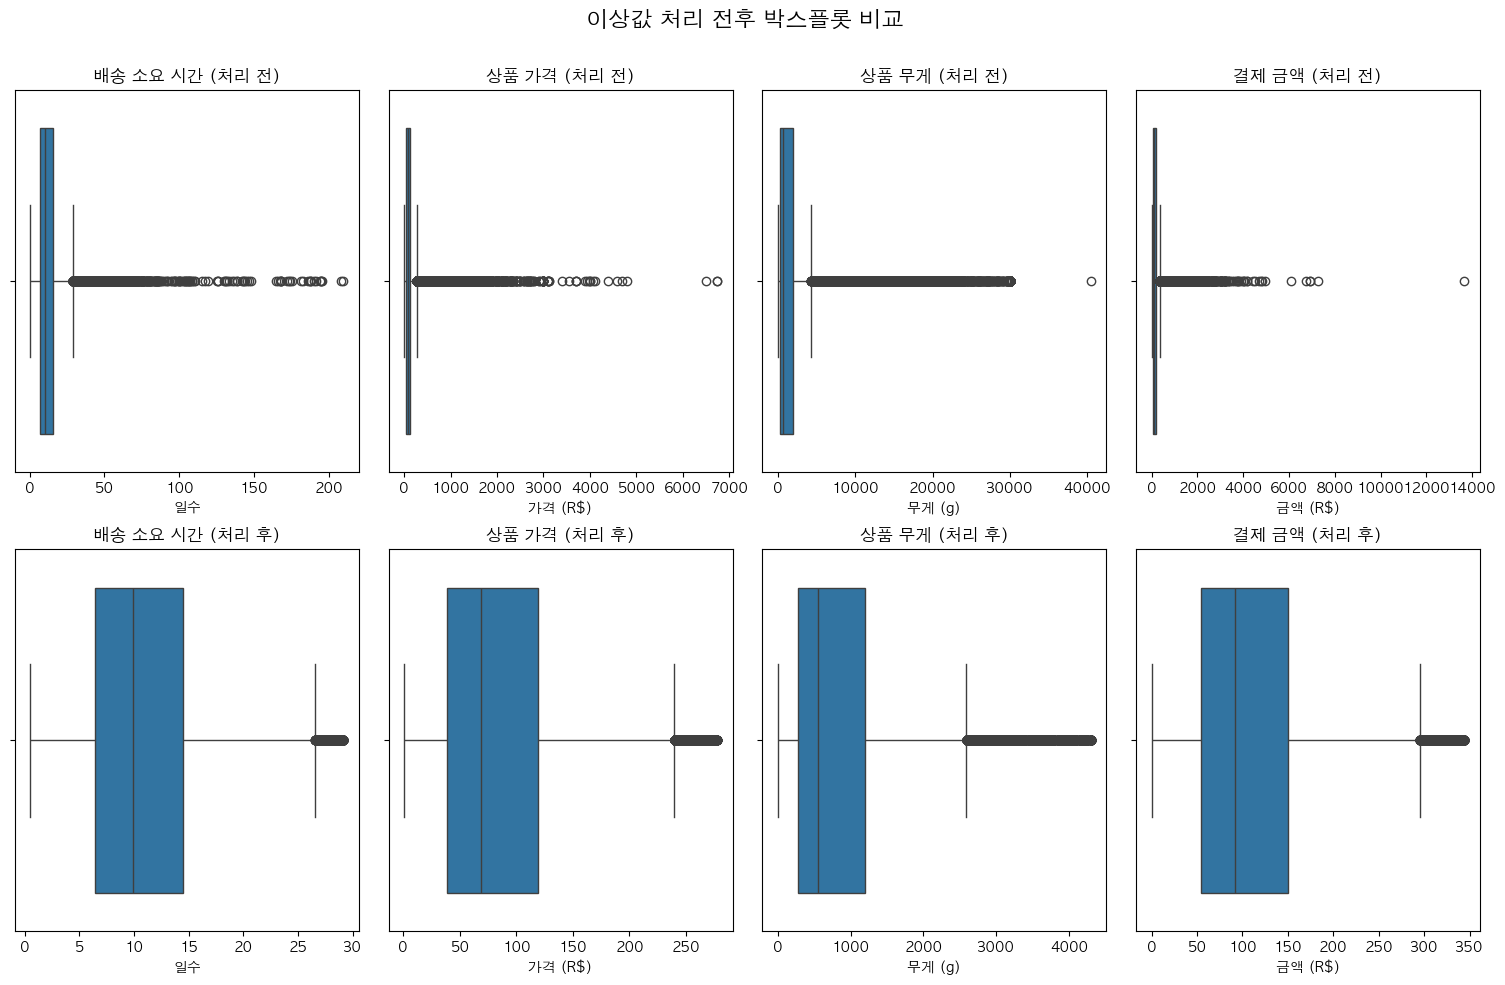

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터셋 불러오기
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")

# 폰트 깨짐 방지: Matplotlib에 한글 폰트 설정
plt.rc('font', family='AppleGothic')
# 마이너스 기호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# orders 데이터 날짜 변환 및 배송 소요 시간 계산
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders.dropna(subset=['order_delivered_customer_date'], inplace=True)
orders['delivery_time_days'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# 시각화를 위한 원본 데이터 복사
orders_original = orders.copy()
order_items_original = order_items.copy()
products_original = products.copy()
payments_original = payments.copy()

# =================================================================
# 이상값 처리 및 시각화
# =================================================================

fig, axes = plt.subplots(2, 4, figsize=(15, 10))
fig.suptitle('이상값 처리 전후 박스플롯 비교', fontsize=16)

# ----------------- 배송 소요 시간 (orders) -----------------
# 처리 전
sns.boxplot(x=orders_original['delivery_time_days'], ax=axes[0, 0])
axes[0, 0].set_title('배송 소요 시간 (처리 전)')
axes[0, 0].set_xlabel('일수')

# 이상값 처리
Q1 = orders['delivery_time_days'].quantile(0.25)
Q3 = orders['delivery_time_days'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
orders_cleaned = orders[(orders['delivery_time_days'] >= lower_bound) & (orders['delivery_time_days'] <= upper_bound)]

# 처리 후
sns.boxplot(x=orders_cleaned['delivery_time_days'], ax=axes[1, 0])
axes[1, 0].set_title('배송 소요 시간 (처리 후)')
axes[1, 0].set_xlabel('일수')

# ----------------- 상품 가격 (order_items) -----------------
# 처리 전
sns.boxplot(x=order_items_original['price'], ax=axes[0, 1])
axes[0, 1].set_title('상품 가격 (처리 전)')
axes[0, 1].set_xlabel('가격 (R$)')

# 이상값 처리
Q1 = order_items['price'].quantile(0.25)
Q3 = order_items['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
order_items_cleaned = order_items[(order_items['price'] >= lower_bound) & (order_items['price'] <= upper_bound)]

# 처리 후
sns.boxplot(x=order_items_cleaned['price'], ax=axes[1, 1])
axes[1, 1].set_title('상품 가격 (처리 후)')
axes[1, 1].set_xlabel('가격 (R$)')

# ----------------- 상품 무게 (products) -----------------
# 처리 전
sns.boxplot(x=products_original['product_weight_g'], ax=axes[0, 2])
axes[0, 2].set_title('상품 무게 (처리 전)')
axes[0, 2].set_xlabel('무게 (g)')

# 이상값 처리
Q1 = products['product_weight_g'].quantile(0.25)
Q3 = products['product_weight_g'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
products_cleaned = products[(products['product_weight_g'] >= lower_bound) & (products['product_weight_g'] <= upper_bound)]

# 처리 후
sns.boxplot(x=products_cleaned['product_weight_g'], ax=axes[1, 2])
axes[1, 2].set_title('상품 무게 (처리 후)')
axes[1, 2].set_xlabel('무게 (g)')

# ----------------- 결제 금액 (payments) -----------------
# 처리 전
sns.boxplot(x=payments_original['payment_value'], ax=axes[0, 3])
axes[0, 3].set_title('결제 금액 (처리 전)')
axes[0, 3].set_xlabel('금액 (R$)')

# 이상값 처리
Q1 = payments['payment_value'].quantile(0.25)
Q3 = payments['payment_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
payments_cleaned = payments[(payments['payment_value'] >= lower_bound) & (payments['payment_value'] <= upper_bound)]

# 처리 후
sns.boxplot(x=payments_cleaned['payment_value'], ax=axes[1, 3])
axes[1, 3].set_title('결제 금액 (처리 후)')
axes[1, 3].set_xlabel('금액 (R$)')

# 전체 레이아웃 조정
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()



### 데이터 병합 merge 및 중복값 제거 

In [5]:

# orders와 customers 병합 (customer_id 기준)
df_merged = pd.merge(orders, customers, on='customer_id', how='left')

# df_merged와 order_items 병합 (order_id 기준)
df_merged = pd.merge(df_merged, order_items, on='order_id', how='left')

# df_merged와 payments 병합 (order_id 기준)
df_merged = pd.merge(df_merged, payments, on='order_id', how='left')

# df_merged와 reviews 병합 (order_id 기준)
df_merged = pd.merge(df_merged, reviews, on='order_id', how='left')

# df_merged와 products 병합 (product_id 기준)
df_merged = pd.merge(df_merged, products, on='product_id', how='left')

# df_merged와 sellers 병합 (seller_id 기준)
df_merged = pd.merge(df_merged, sellers, on='seller_id', how='left')

# df_merged와 category_name 병합 (product_category_name 기준)
df_merged = pd.merge(df_merged, category_name, on='product_category_name', how='left')

# geolocation 데이터는 다대다 관계이므로, 추후에 필요에 따라 병합
# 현재는 geolocation_zip_code_prefix를 기준으로 고객 및 판매자 지역을 분석

# 최종 데이터프레임 미리보기
print("\n\n=== 모든 데이터셋 병합 후 최종 데이터프레임 ===")
print("데이터 크기:", df_merged.shape)
print(df_merged.head())

# 모든 컬럼이 동일한 중복 행을 제거합니다.
# 특히 여러 데이터셋을 병합하는 과정에서 중복이 발생할 수 있습니다.
initial_rows = df_merged.shape[0]
df_merged.drop_duplicates(inplace=True)
cleaned_rows = df_merged.shape[0]

print("\n=== 중복값 처리 현황 ===")
print(f"처리 전 행 수: {initial_rows}")
print(f"중복 제거 후 행 수: {cleaned_rows}")
print(f"제거된 중복 행 수: {initial_rows - cleaned_rows}")




=== 모든 데이터셋 병합 후 최종 데이터프레임 ===
데이터 크기: (115722, 41)
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:

### 추가 파생 변수 생성 

In [6]:
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])
df_merged['order_delivered_customer_date'] = pd.to_datetime(df_merged['order_delivered_customer_date'])
df_merged['order_estimated_delivery_date'] = pd.to_datetime(df_merged['order_estimated_delivery_date'])

#추가 파생 변수 생성 
# 배송 소요 시간 (delivery_time_days)
df_merged['delivery_time_days'] = (df_merged['order_delivered_customer_date'] - df_merged['order_purchase_timestamp']).dt.total_seconds() / (24 * 3600)

# 배송 지연 여부 (delivery_delay)
df_merged['delivery_delay'] = (df_merged['order_delivered_customer_date'] - df_merged['order_estimated_delivery_date']).dt.total_seconds() / (24 * 3600)

# 구매 시간 관련 변수
df_merged['order_purchase_year'] = df_merged['order_purchase_timestamp'].dt.year
df_merged['order_purchase_month'] = df_merged['order_purchase_timestamp'].dt.month
df_merged['order_purchase_dayofweek'] = df_merged['order_purchase_timestamp'].dt.dayofweek
df_merged['order_purchase_hour'] = df_merged['order_purchase_timestamp'].dt.hour



df_merged.to_csv("olist_master_clean.csv", index=False)



***코드 진행 내용 요약***

제출해주신 코드는 크게 네 가지 단계로 진행되었습니다.

1. 데이터 불러오기 및 결측치 확인: 필요한 라이브러리를 임포트하고 9개의 CSV 파일을 로드했습니다. orders 데이터셋의 결측치를 확인하고, 배송 및 결제 관련 결측 행을 제거했습니다. reviews 데이터셋의 코멘트 결측치는 'no comment'로 채웠습니다.

2. 이상값 처리 및 시각화: orders (delivery_time_days), order_items (price), products (product_weight_g), payments (payment_value) 데이터셋의 주요 수치형 변수들에 대해 IQR(사분위 범위)을 활용한 이상값 처리를 진행했습니다. 이상값 처리 전후의 변화를 2행 4열의 박스플롯으로 시각화하여 한눈에 비교할 수 있도록 했습니다.

3. 데이터 병합: customers, orders, order_items, payments 데이터셋을 순차적으로 병합하여 하나의 통합된 데이터프레임(df_merged)을 만들었습니다. 이 과정에서 order_id에 결측치가 있는 행을 제거했습니다.

4. 파생 변수 생성 및 저장: 병합된 데이터프레임에서 delivery_days, delivery_delay, order_year, order_month, order_dayofweek와 같은 새로운 파생 변수들을 생성했습니다. 마지막으로 이 데이터를 olist_master_clean.csv 파일로 저장했습니다.



In [7]:


# 9개의 CSV 파일 경로를 리스트로 정의합니다.
file_list = [
    "olist_customers_dataset.csv",
    "olist_geolocation_dataset.csv",
    "olist_order_items_dataset.csv",
    "olist_order_payments_dataset.csv",
    "olist_order_reviews_dataset.csv",
    "olist_orders_dataset.csv",
    "olist_products_dataset.csv",
    "olist_sellers_dataset.csv",
    "product_category_name_translation.csv"
]

# 각 파일을 순회하며 컬럼명을 출력합니다.
print("=== 각 데이터셋의 컬럼명 ===")
print("-" * 30)

for file in file_list:
    try:
        # CSV 파일을 데이터프레임으로 읽어옵니다.
        df = pd.read_csv(file)
        
        # 파일 이름을 출력합니다.
        print(f"파일: {file}")
        
        # 컬럼명 리스트를 출력합니다.
        print("컬럼명:", df.columns.tolist())
        print("-" * 30)
    
    except FileNotFoundError:
        print(f"오류: {file} 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        print("-" * 30)



=== 각 데이터셋의 컬럼명 ===
------------------------------
파일: olist_customers_dataset.csv
컬럼명: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
------------------------------
파일: olist_geolocation_dataset.csv
컬럼명: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
------------------------------
파일: olist_order_items_dataset.csv
컬럼명: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
------------------------------
파일: olist_order_payments_dataset.csv
컬럼명: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
------------------------------
파일: olist_order_reviews_dataset.csv
컬럼명: ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']
------------------------------
파일: olist_orders_dataset.csv
컬럼명: ['order_i

# 1. 고객 세분화 및 RFM 분석  

- 브라질 지역별 고객들의 구매 패턴을 분석하여 RFM(Recency, Frequency, Monetary) 모델을 구축하고, 고객을 세분화하여 각 세그먼트의 특성과 비즈니스 전략을 제시하세요.

### RFM 변수 계산 및 상관관계 시각화 


분석 기준일: 2018-08-30

=== RFM 지표 계산 결과 미리보기 ===
                 customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    129.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     18.90
2  0000f46a3911fa3c0805444483337064      537          1     69.00
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     25.99
4  0004aac84e0df4da2b147fca70cf8255      288          1    180.00


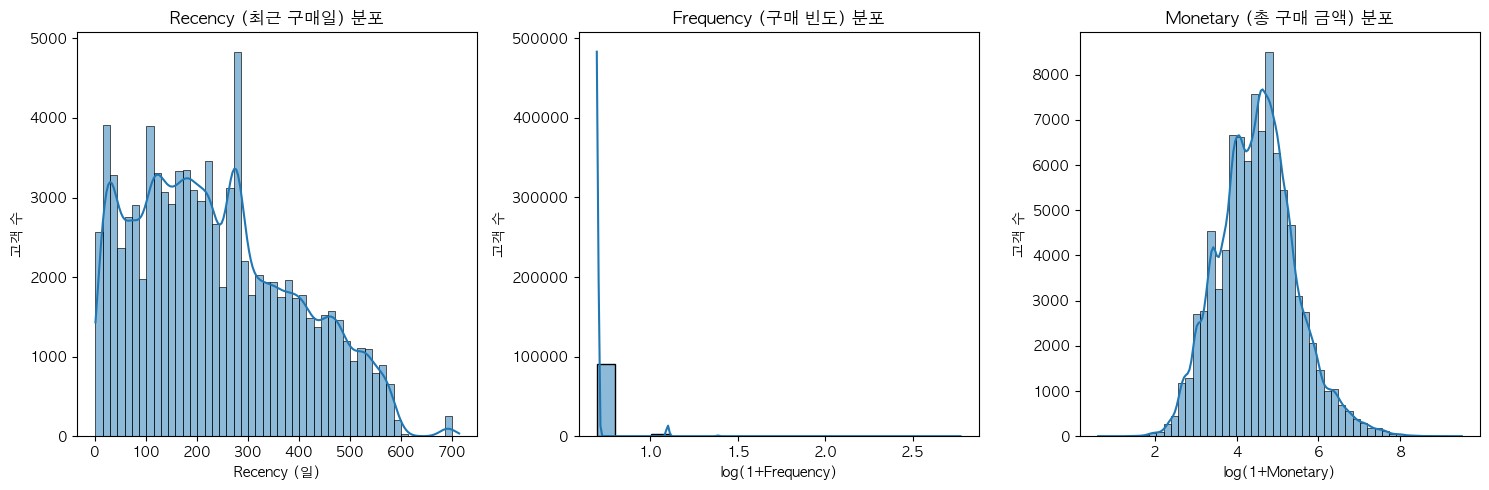


=== RFM 변수 간의 상관관계(Correlation) ===
            Recency  Frequency  Monetary
Recency    1.000000  -0.022268  0.005314
Frequency -0.022268   1.000000  0.109986
Monetary   0.005314   0.109986  1.000000


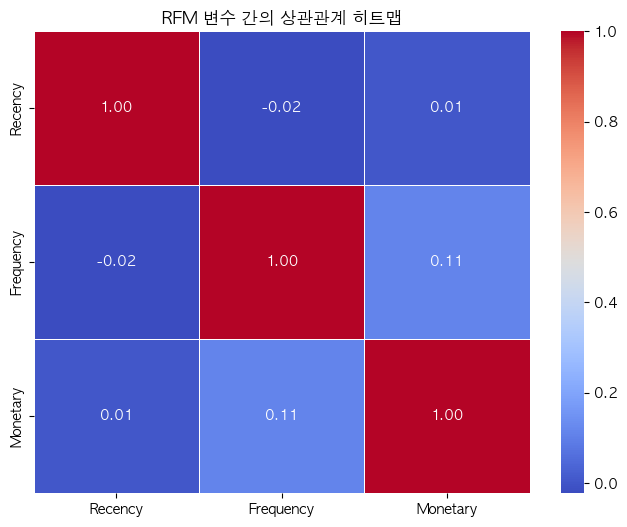

In [8]:
# 최종 데이터셋 불러오기
df_merged = pd.read_csv("olist_master_clean.csv")

# 날짜/시간 컬럼을 datetime 타입으로 변환
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])
df_merged['order_delivered_customer_date'] = pd.to_datetime(df_merged['order_delivered_customer_date'])

# 분석 기준일 설정 (가장 최근 주문일 + 1일)
# 데이터셋의 가장 최근 주문일을 기준으로 Recency를 계산합니다.
last_order_date = df_merged['order_purchase_timestamp'].max()
analysis_date = last_order_date + pd.Timedelta(days=1)

print(f"분석 기준일: {analysis_date.date()}")

# 'customer_unique_id'를 기준으로 RFM 지표 계산
rfm_df = df_merged.groupby('customer_unique_id').agg({
    # Recency: 최근 구매일
    'order_purchase_timestamp': lambda date: (analysis_date - date.max()).days,
    # Frequency: 구매 횟수 (고유한 order_id의 수)
    'order_id': 'nunique',
    # Monetary: 총 구매 금액
    'price': 'sum'
}).reset_index()


# 컬럼명 변경
rfm_df.columns = ['customer_unique_id', 'Recency', 'Frequency', 'Monetary']

print("\n=== RFM 지표 계산 결과 미리보기 ===")
print(rfm_df.head())


# =================================================================
# RFM 변수 분포 시각화
# =================================================================

plt.figure(figsize=(15, 5))

# Recency 히스토그램
plt.subplot(1, 3, 1)
sns.histplot(rfm_df['Recency'], bins=50, kde=True)
plt.title('Recency (최근 구매일) 분포')
plt.xlabel('Recency (일)')
plt.ylabel('고객 수')

# Frequency 히스토그램
plt.subplot(1, 3, 2)
# Frequency는 대부분 1이므로, 로그 스케일을 적용하여 분포를 더 잘 보이게 합니다.
sns.histplot(np.log1p(rfm_df['Frequency']), bins=20, kde=True)
plt.title('Frequency (구매 빈도) 분포')
plt.xlabel('log(1+Frequency)')
plt.ylabel('고객 수')

# Monetary 히스토그램
plt.subplot(1, 3, 3)
# Monetary도 치우친 분포를 보일 수 있어, 로그 스케일을 적용합니다.
sns.histplot(np.log1p(rfm_df['Monetary']), bins=50, kde=True)
plt.title('Monetary (총 구매 금액) 분포')
plt.xlabel('log(1+Monetary)')
plt.ylabel('고객 수')

plt.tight_layout()
plt.show()

print("\n=== RFM 변수 간의 상관관계(Correlation) ===")
print(rfm_df[['Recency', 'Frequency', 'Monetary']].corr())

# RFM 변수 간의 상관관계 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_df[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('RFM 변수 간의 상관관계 히트맵')
plt.show()





In [9]:
print(customers.head(3))

                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  


### 클러스터링/ 스코어링 기반 세그먼트 나누기 

In [10]:

# RFM 지표 계산 결과 데이터프레임 불러오기
#이 코드는 rfm-calculation 코드가 먼저 실행되어 rfm_df가 생성되어야 합니다.

# R, F, M 점수 부여 (1~5점 척도)
# Recency는 낮을수록 좋은 점수
rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
# Frequency와 Monetary는 높을수록 좋은 점수
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)

# RFM 점수를 합산하여 최종 점수 생성
rfm_df['RFM_Score'] = rfm_df['R_Score'] + rfm_df['F_Score'] + rfm_df['M_Score']

# 세그먼트 분류 함수 정의
def rfm_segment(rfm_score):
    """
    RFM 점수 합계에 따라 고객 세그먼트를 분류하는 함수
    """
    if rfm_score >= 12:
        return '최우수 고객 (Champions)'
    elif rfm_score >= 10:
        return '충성 고객 (Loyal Customers)'
    elif rfm_score >= 8:
        return '잠재 고객 (Potential Loyalists)'
    elif rfm_score >= 6:
        return '신규 고객 (New Customers)'
    elif rfm_score >= 4:
        return '이탈 위험 고객 (At Risk)'
    else:
        return '휴면 고객 (Lost Customers)'

# RFM 점수를 기준으로 세그먼트 분류
rfm_df['Segment'] = rfm_df['RFM_Score'].apply(rfm_segment)

# 세그먼트별 고객 수 확인
segment_counts = rfm_df['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

print("=== 고객 세그먼트별 분포 ===")
print(segment_counts)

print("\n=== 세그먼트 분류 결과 미리보기 ===")
print(rfm_df.head())


=== 고객 세그먼트별 분포 ===
                       Segment  Count
0  잠재 고객 (Potential Loyalists)  27294
1      충성 고객 (Loyal Customers)  24075
2        신규 고객 (New Customers)  18649
3           최우수 고객 (Champions)  15511
4           이탈 위험 고객 (At Risk)   6994
5       휴면 고객 (Lost Customers)    833

=== 세그먼트 분류 결과 미리보기 ===
                 customer_unique_id  Recency  Frequency  Monetary  R_Score  \
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1    129.90        4   
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1     18.90        4   
2  0000f46a3911fa3c0805444483337064      537          1     69.00        1   
3  0000f6ccb0745a6a4b88665a16c9f078      321          1     25.99        2   
4  0004aac84e0df4da2b147fca70cf8255      288          1    180.00        2   

   F_Score  M_Score  RFM_Score                      Segment  
0        1        4          9  잠재 고객 (Potential Loyalists)  
1        1        1          6        신규 고객 (New Customers)  
2        1        2          4    

=== 지역별 RFM 평균 지표 ===
   customer_state     Recency  Frequency    Monetary  RFM_Score
0              AC  305.842105   1.052632  223.782368   8.671053
1              AL  265.564433   1.025773  212.835644   9.206186
2              AM  260.600000   1.035714  161.887571   8.735714
3              AP  244.166667   1.015152  205.375909   9.681818
4              BA  242.841672   1.031666  165.733182   9.089297
5              CE  253.565978   1.018283  185.131320   9.050079
6              DF  225.638930   1.032194  153.201758   9.172858
7              ES  243.303423   1.035270  144.284772   8.930498
8              GO  243.449604   1.035356  159.705968   9.083905
9              MA  262.137143   1.028571  172.546343   8.968571
10             MG  243.013087   1.032900  146.640716   9.007634
11             MS  232.603524   1.030837  176.208223   9.082232
12             MT  244.577103   1.037383  182.355643   9.155374
13             PA  264.121475   1.026030  195.675390   9.036876
14             PB 

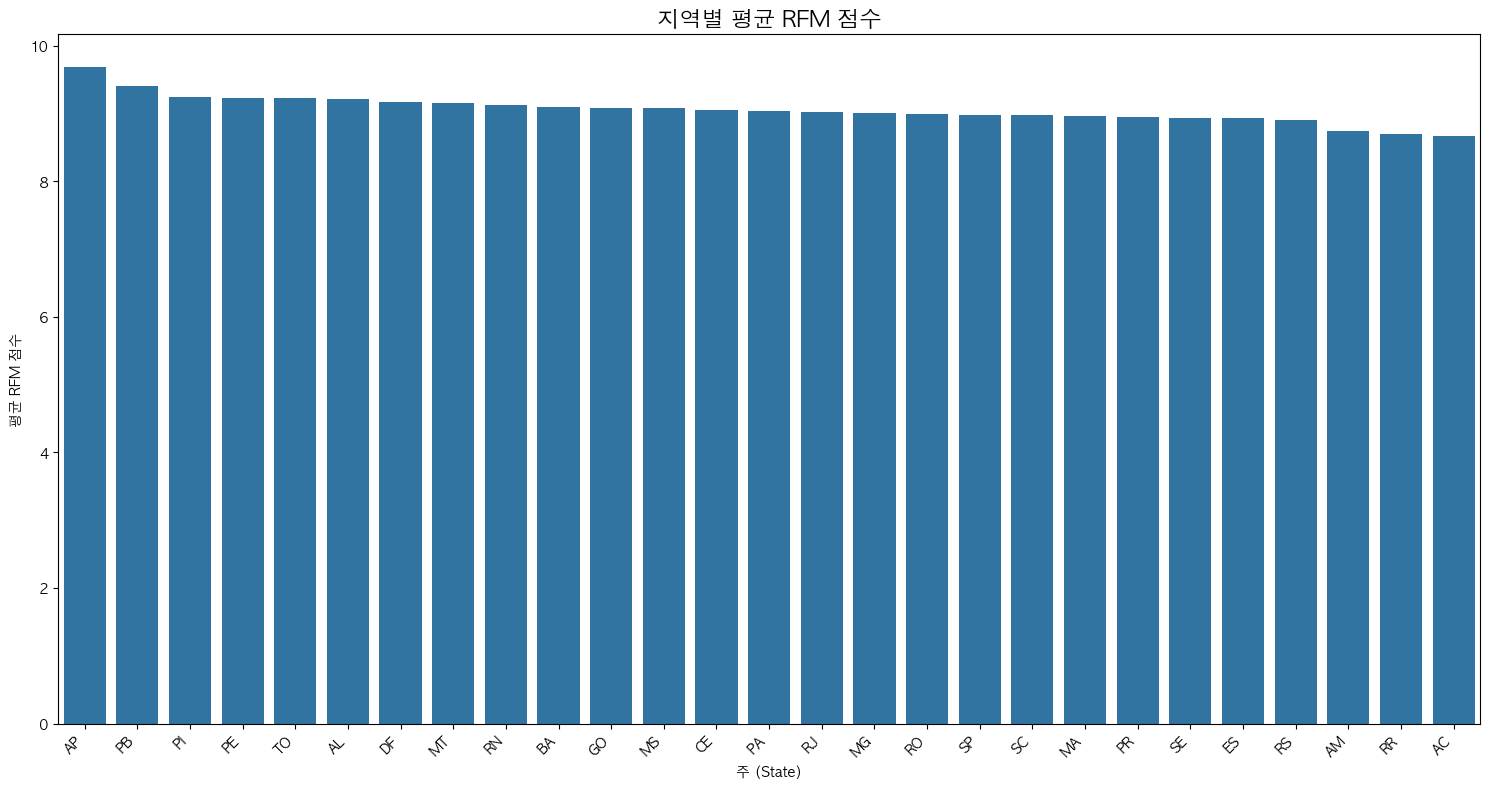

<Figure size 1500x800 with 0 Axes>

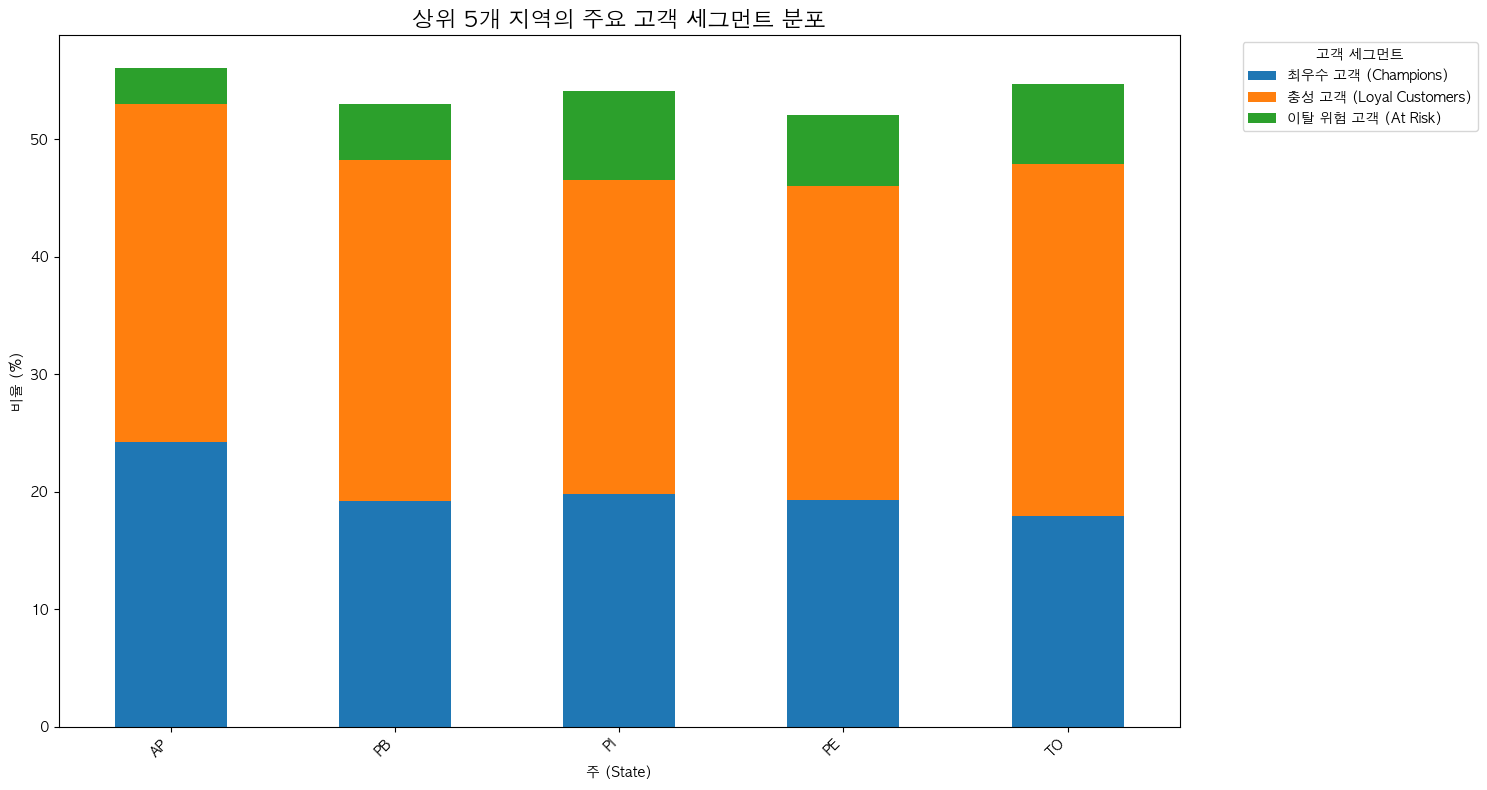

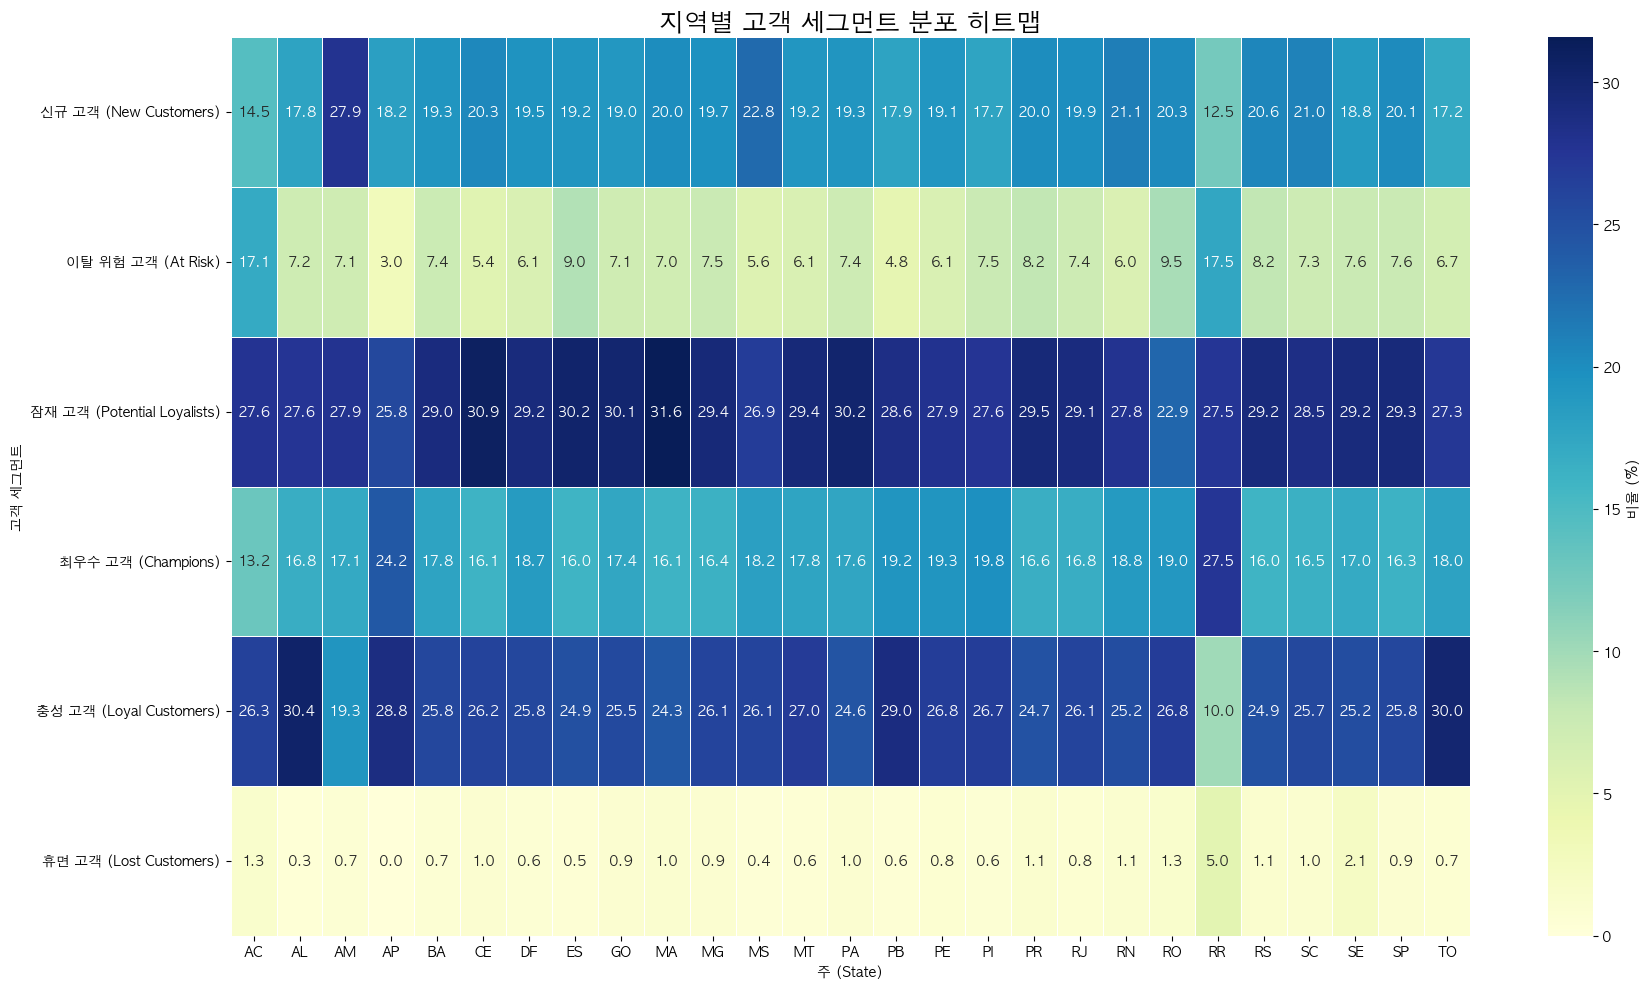

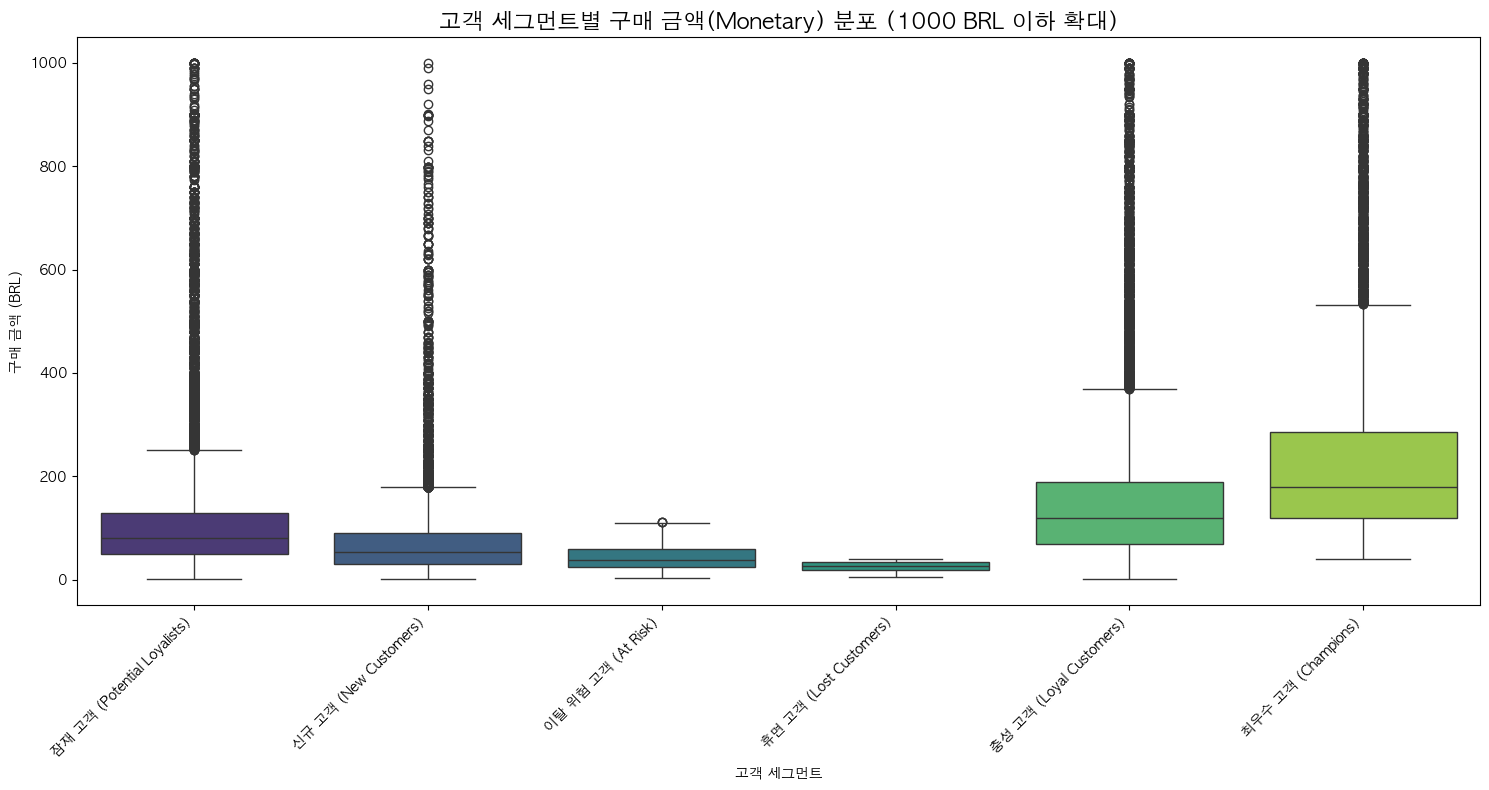

In [11]:


# 폰트 깨짐 방지: Matplotlib에 한글 폰트 설정
plt.rc('font', family='AppleGothic')
# 마이너스 기호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# 기존에 병합했던 최종 데이터셋을 불러옵니다.
df_merged = pd.read_csv("olist_master_clean.csv")


# customers와 rfm_df를 customer_unique_id 기준으로 병합
# 동일한 customer_unique_id를 가진 고객이 여러 주소를 가질 수 있어, 중복 제거 후 병합
customer_locations = customers[['customer_unique_id', 'customer_state']].drop_duplicates()
rfm_regional = pd.merge(rfm_df, customer_locations, on='customer_unique_id', how='left')


# =================================================================
# 1. 지역별 RFM 패턴 분석
# =================================================================

# 지역별 RFM 평균 지표 계산
regional_summary = rfm_regional.groupby('customer_state').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': 'mean'
}).reset_index()

# 지역별 세그먼트 분포 계산
regional_segment_distribution = rfm_regional.groupby('customer_state')['Segment'].value_counts(normalize=True).unstack(fill_value=0) * 100

print("=== 지역별 RFM 평균 지표 ===")
print(regional_summary)

print("\n\n=== 지역별 고객 세그먼트 분포 (%) ===")
print(regional_segment_distribution)


# =================================================================
# 2. 세그먼트별 특성 및 평균 지표 분석
# =================================================================

# 세그먼트별 평균 RFM 지표 계산
segment_summary = rfm_regional.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'RFM_Score': 'mean'
}).reset_index()

print("\n\n=== 세그먼트별 평균 RFM 지표 ===")
# Monetary 값을 보기 쉽게 반올림
segment_summary['Monetary'] = segment_summary['Monetary'].round(2)
print(segment_summary.sort_values('RFM_Score', ascending=False))


# =================================================================
# 3. 시각화
# =================================================================

# 3-1. RFM 점수를 기준으로 지역별 패턴 시각화 (기존 코드)
plt.figure(figsize=(15, 8))
sns.barplot(data=regional_summary.sort_values('RFM_Score', ascending=False), x='customer_state', y='RFM_Score')
plt.title('지역별 평균 RFM 점수', fontsize=16)
plt.xlabel('주 (State)')
plt.ylabel('평균 RFM 점수')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3-2. 주요 세그먼트 분포 시각화 (기존 코드)
top_states = regional_summary.sort_values('RFM_Score', ascending=False).head(5)['customer_state'].tolist()
top_states_df = regional_segment_distribution.loc[top_states]

plt.figure(figsize=(15, 8))
top_states_df[['최우수 고객 (Champions)', '충성 고객 (Loyal Customers)', '이탈 위험 고객 (At Risk)']].plot(kind='bar', stacked=True, figsize=(15, 8))
plt.title('상위 5개 지역의 주요 고객 세그먼트 분포', fontsize=16)
plt.xlabel('주 (State)')
plt.ylabel('비율 (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='고객 세그먼트', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# 3-3. 세그먼트와 지역의 상관관계 시각화 (히트맵)
# Heatmap으로 지역별 세그먼트 분포 시각화
plt.figure(figsize=(18, 10))
sns.heatmap(regional_segment_distribution.T, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1f", cbar_kws={'label': '비율 (%)'})
plt.title('지역별 고객 세그먼트 분포 히트맵', fontsize=18)
plt.xlabel('주 (State)')
plt.ylabel('고객 세그먼트')
plt.tight_layout()
plt.show()


# 구매 금액이 1000 BRL 이하인 데이터만 포함하여 확대된 박스플롯
plt.figure(figsize=(15, 8))
sns.boxplot(x='Segment', y='Monetary', data=rfm_regional[rfm_regional['Monetary'] <= 1000], palette="viridis")
plt.title('고객 세그먼트별 구매 금액(Monetary) 분포 (1000 BRL 이하 확대)', fontsize=16)
plt.xlabel('고객 세그먼트')
plt.ylabel('구매 금액 (BRL)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



### 1.고객 세그먼트 분석 및 비즈니스 전략 (히트맵, 박스플롯 기법 기반)
세그먼트별 특성 및 비즈니스 전략
1. 최우수 고객 (Champions) & 충성 고객 (Loyal Customers)

특성: 이 그룹은 가장 높은 빈도와 금액으로 구매하며, 특히 **상파울루(SP)**와 같은 특정 지역에 집중되어 있습니다. 박스플롯에서 이 세그먼트의 높은 중앙값과 함께 **고액 구매자(이상치)**가 다수 발견됩니다.

전략: 이들을 유지하고 이탈을 방지하는 것이 최우선입니다. VIP 전용 서비스, 독점 할인, 맞춤형 추천, 그리고 감사 이벤트 등을 통해 브랜드에 대한 충성도를 더욱 강화해야 합니다.

2. 잠재 고객 (Potential Loyalists)

특성: 이들은 최근에 구매했지만, 아직 구매 빈도나 금액은 높지 않은 고객들입니다. 히트맵에서 보듯이 대부분의 주에서 가장 높은 비중을 차지합니다.

전략: 이들을 충성 고객으로 전환시키는 것이 중요합니다. 첫 구매 이후 재구매를 유도하는 맞춤형 쿠폰, 포인트 적립 혜택, 그리고 관심 있을 만한 상품을 추천하는 개인화된 마케팅을 진행해야 합니다.

3. 이탈 위험 고객 (At Risk) & 휴면 고객 (Lost Customers)

특성: 이들은 최근 구매 활동이 뜸해진 고객들입니다. 특히 이탈 위험 고객은 알라고아스(AL) 주에서 높은 비중을 차지합니다.

전략: 이들을 재활성화하는 것이 목표입니다. 맞춤형 할인, 재구매 시 특별 혜택, 또는 고객의 과거 구매 이력을 바탕으로 한 추천을 통해 다시 한번 구매를 유도하는 캠페인을 전개해야 합니다.




---

### 2.고객 그룹별 맞춤형 마케팅 전략
우선, RFM 점수를 기준으로 고객을 몇 개의 그룹으로 나누고, 각 그룹에 맞는 전략을 적용할 수 있습니다. 예를 들어, 다음과 같은 그룹을 고려해 볼 수 있습니다.

1. 최우수 고객 (Champions) 👑
특징: 최근에 구매했고, 구매 횟수와 금액 모두 높은 고객.

전략: 이들이 계속해서 구매할 수 있도록 VIP 혜택을 제공하고, 신제품 또는 독점 프로모션에 대한 정보를 먼저 제공하여 충성도를 높입니다.

2. 충성 고객 (Loyal Customers) 🤝
특징: 꾸준히 구매하며, 구매 횟수가 높은 고객.

전략: 재구매를 유도하기 위한 개인화된 할인 쿠폰을 제공하고, 이들이 자주 구매하는 상품을 기반으로 맞춤형 추천을 합니다.

3. 잠재적 이탈 고객 (At-Risk) 🚨
특징: 최근 구매일이 오래되었고, 구매 횟수와 금액이 보통인 고객.

전략: 재활성화 캠페인을 진행합니다. 예를 들어, '오랜만에 방문해주셔서 감사합니다'와 같은 메시지와 함께 특별 할인 혜택을 제공하여 재방문을 유도합니다.

4. 신규 고객 (New Customers) 🌱
특징: 최근에 처음 구매한 고객.

전략: 첫 구매 경험에 만족할 수 있도록 구매한 상품에 대한 사용 팁이나 관련 상품 정보를 제공하여 다음 구매를 유도합니다. 이메일이나 앱 알림을 통해 지속적으로 관계를 구축해야 합니다.